# Imports

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Data Files

In [8]:
import glob

# Define a function to parse C++-style complex numbers
def parse_cpp_complex(s):
    return complex(*map(float, s.strip("()").split(',')))


# Find all text files starting with "out"
fileListData = glob.glob("out*.txt")

# Organize the data into arrays
dataArr = []
for file in fileListData:
    _, prefix, N, n0, sig, k0, field = file.split("-")
    N, n0, sig, k0, field = int(N), int(n0), int(sig), float(k0), float(field[:-4])
    
    # Load the file as an array of strings
    data = np.genfromtxt(file, dtype=str)
    data = np.array([[parse_cpp_complex(num) for num in data[i]] for i in range(len(data))], dtype=np.complex128)

    dataArr += [(prefix, N, n0, sig, k0, field, data)]



# Find all text files starting with "time"
fileListTime = glob.glob("time*.txt") 

# Find all text files starting with "time"
fileListTime = glob.glob("time*.txt")

# Get time data
ttArr, rrArr, uuArr = [], [], []
for fileName in fileListTime:
    with open(fileName, "r") as file:
        text = file.read().split("\n")
        text = [item for item in text if len(item) > 2]

    tt, rr, uu = [], [], []

    # Timing itself
    for item in text:
        item = item.split()
        tt += [int(item[5][:-1])]
        rr += [float(item[6])]

    ttArr += [tt]
    rrArr += [rr]
    uuArr += [uu]

ttArr = np.array(ttArr)
rrArr = np.array(rrArr)
uuArr = np.array(uuArr)

# Visualization

In [9]:
def stats(dataTuple: tuple):
    # Extract the data
    prefix, N, n0, sig, k0, field, data = dataTuple

    # Compute mean and variance
    prob = np.abs(data) ** 2
    prob = prob / np.sum(prob, axis=1, keepdims=True)
    
    mm = np.sum(np.arange(N) * prob, axis=1)
    mm2 = np.sum(np.arange(N) ** 2 * prob, axis=1)
    vv = mm2 - mm**2

    # Compute normalization
    normalization = np.sum(prob, axis=1, keepdims=True)

    # Show result at the initial state as a sanity check
    print(f"For t = 0 we have average = {mm[0]:.3f} and variance = {vv[0]:.3f}")
    print(f"Normalization constant average = {np.average(normalization):.3f} and variance = {np.var(normalization):.3f}")

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
    
    # Title based on prefix
    if prefix == "real":
        fig.suptitle(f"Statistics of the Wave function for N={N}, n0={n0}, sig={sig}, k0={k0} and E = {field}")
    else:
        fig.suptitle(f"Statistics of the Fourier transform for N={N}, n0={n0}, sig={sig}, k0={k0} and E = {field}")
    
    # Plot mean
    axes[0].plot(mm, label="Mean", color='b')
    axes[0].set_ylabel("Mean")
    axes[0].set_xlabel("Timestep")
    axes[0].legend()
    
    # Plot variance
    axes[1].plot(vv, label="Variance", color='r')
    axes[1].set_ylabel("Variance")
    axes[0].set_xlabel("Timestep")
    axes[1].legend()
    
    # Show plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [10]:
# Imports
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image


#  Update rule for the video
timestep = 0
def update(frame, prefix, line, ax, data):
    global timestep

    # Update time
    timestep += 1
    if prefix == "real":
        ax.set_title(f"Wave function at time step {timestep}.")
    else:
        ax.set_title(f"Fourier components at time step {timestep}.")

    # Update line data
    line.set_ydata(np.abs(data[frame, :]))

    return line,


# Make the video
def makeGIF(dataTuple: tuple, maxFrames: int = 100):
    global timestep

    # Extract the data
    prefix, N, n0, sig, k0, field, data = dataTuple

    # Use only every skip item
    skip = int(len(data[:, 0]) / maxFrames + 1)
    data = abs(data[0::skip, :])**2

    # Start the plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
    ax.grid(True)

    if prefix == "real":
        ax.set_title("Wave function at time step 0.")
        ax.set_xlabel("Position along the lattice (n)")
        ax.set_ylabel("Modulus of wave function $|\\psi(n, t)|$")
    else:
        ax.set_title("Fourier components at time step 0.")
        ax.set_xlabel("Wave vector index ($\\ell$)")
        ax.set_ylabel("Modulus of component $|\\psi(\\ell, t)|$")

    # First frame
    x_values = np.arange(0, N)
    line, = ax.plot(x_values, np.abs(data[0, :]), c="b") 

    # Reset timestep
    timestep = 0

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(data[:, 0]), fargs=(prefix, line, ax, data), interval=100)

    # Save animation
    ani.save(f"wave-{prefix}-{N}-{n0}-{sig}-{k0}-{field}.gif", writer="pillow")
    plt.close()

# Statistics

For t = 0 we have average = 261.511 and variance = 32.445
Normalization constant average = 1.000 and variance = 0.000


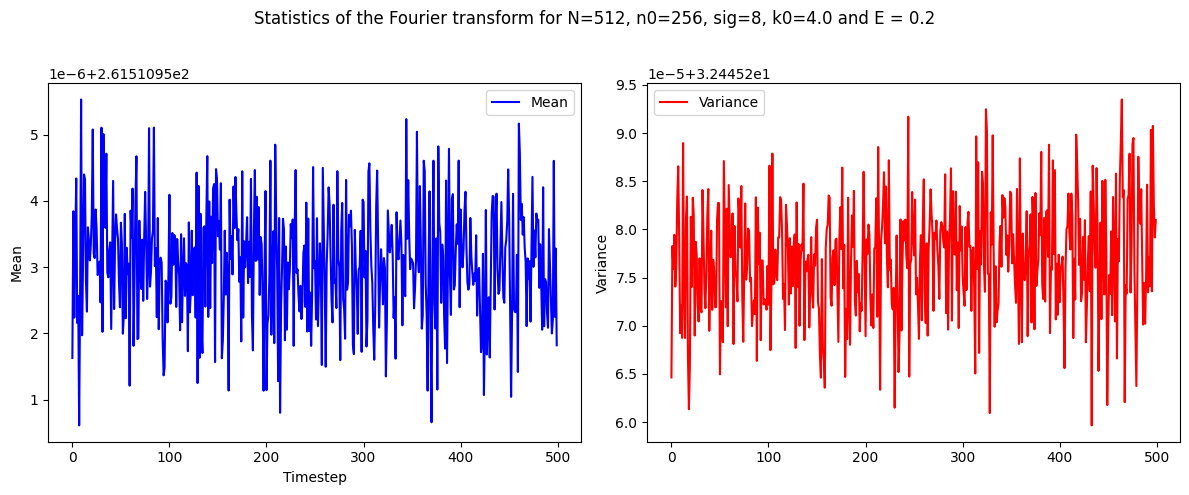

For t = 0 we have average = 256.000 and variance = 32.000
Normalization constant average = 1.000 and variance = 0.000


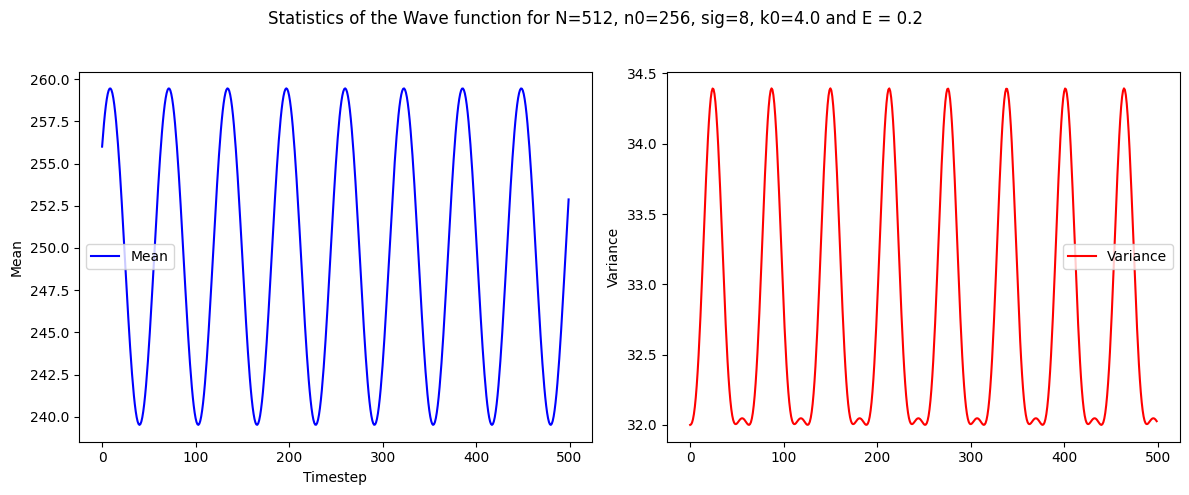

In [11]:
for item in dataArr:
    stats(item)

# Wave Function

In [12]:
# See wave functions
for item in dataArr:
    makeGIF(item)

# Parallelization

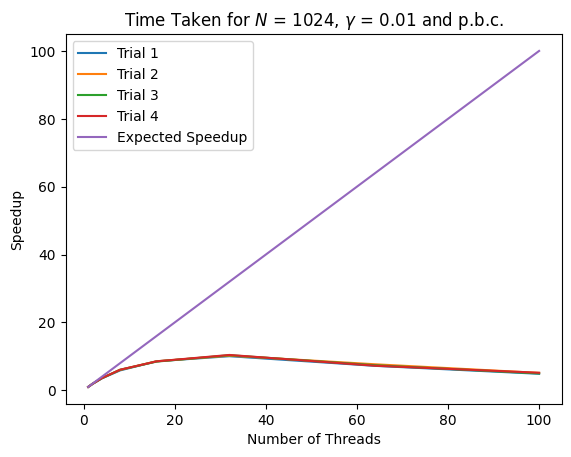

In [13]:
plt.title(f"Time Taken for $N$ = {1024}, $\\gamma$ = {0.01} and {'p.' if True else 'o.'}b.c.")
for tt, rr, index in zip(ttArr, rrArr, range(0, len(ttArr))):
    plt.plot(tt, rr[0] / rr, label=f"Trial {index+1}")

plt.plot(tt, tt, label="Expected Speedup")
plt.xlabel("Number of Threads")
plt.ylabel("Speedup")
plt.legend()